In [13]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
DATA_PATH = '../data/fsrs_synthetic_data.csv'
df = pd.read_csv(DATA_PATH)

df.head()
df.describe(include='all')

,word_id,user_id,word_text,base_difficulty,repeat_count,stability,created_days_ago,personal_difficulty,difficulty,user_rating,next_interval_days,ml_score
count,10000.00000,10000.00000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,algorithm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,1034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,124.42130,NaN,0.427590,7.493200,11.105452,10.086149,0.567924,0.469690,2.911800,10.588600,0.943675
std,2886.89568,14.39162,NaN,0.217808,3.999694,12.956768,9.614401,0.213776,0.215563,0.945891,12.818447,0.102789
min,1.00000,100.00000,NaN,0.100047,1.000000,1.000000,1.000000,0.145305,0.113625,1.000000,1.000000,0.501219
25%,2500.75000,112.00000,NaN,0.246383,4.000000,2.782011,2.967346,0.388544,0.288529,2.000000,2.000000,0.928090
50%,5000.50000,125.00000,NaN,0.395555,7.000000,6.217818,7.054233,0.545987,0.440171,3.000000,6.000000,1.000000
75%,7500.25000,137.00000,NaN,0.586769,11.000000,14.730461,14.134750,0.731520,0.629345,4.000000,14.000000,1.000000


In [15]:
feature_cols = [
    'base_difficulty',
    'personal_difficulty',
    'difficulty',
    'repeat_count',
    'stability',
    'user_rating',
]

X = df[feature_cols]

y_interval = df['next_interval_days']

y_score = df['ml_score']

In [16]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X, y_interval, test_size=0.2, random_state=42
)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y_score, test_size=0.2, random_state=42
)

In [17]:
interval_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )),
])

interval_model.fit(X_train_i, y_train_i)

y_pred_i = interval_model.predict(X_test_i)
mae_i = mean_absolute_error(y_test_i, y_pred_i)
r2_i = r2_score(y_test_i, y_pred_i)

print(f"MAE (interval, days): {mae_i:.3f}")
print(f"R2  (interval): {r2_i:.3f}")

MAE (interval, days): 1.168
R2  (interval): 0.974


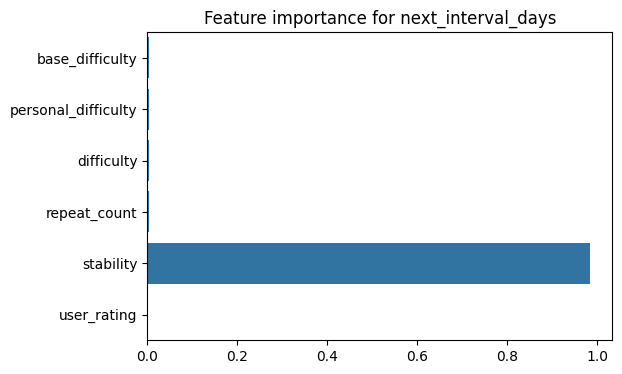

In [18]:
rf_i = interval_model.named_steps['regressor']
importances = rf_i.feature_importances_

plt.figure(figsize=(6,4))
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature importance for next_interval_days")
plt.show()

In [19]:
score_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )),
])

score_model.fit(X_train_s, y_train_s)

y_pred_s = score_model.predict(X_test_s)
mae_s = mean_absolute_error(y_test_s, y_pred_s)
r2_s = r2_score(y_test_s, y_pred_s)

print(f"MAE (ml_score): {mae_s:.3f}")
print(f"R2  (ml_score): {r2_s:.3f}")

MAE (ml_score): 0.000
R2  (ml_score): 1.000


In [20]:
MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

interval_path = os.path.join(MODELS_DIR, 'interval_model.joblib')
score_path = os.path.join(MODELS_DIR, 'ml_score_model.joblib')

joblib.dump(interval_model, interval_path)
joblib.dump(score_model, score_path)

print("Saved:")
print(" -", interval_path)
print(" -", score_path)

Saved:
 - ../models/interval_model.joblib
 - ../models/ml_score_model.joblib


In [21]:
loaded_interval = joblib.load(interval_path)
loaded_score = joblib.load(score_path)

sample = X_test_i.iloc[[0]]
print("Sample features:\n", sample)

print("Loaded interval prediction:", loaded_interval.predict(sample))
print("Loaded ml_score prediction:", loaded_score.predict(sample))

Sample features:
       base_difficulty  personal_difficulty  difficulty  repeat_count  \
6252         0.161345             0.292038    0.200553            14   

      stability  user_rating  
6252  34.022059            3  
Loaded interval prediction: [35.51]
Loaded ml_score prediction: [1.]
